### How to Not Mislead Your Forecasting Model

According to Oxford Dictionary "forecasting" means to say what you think will happen in the future based on information that you have now. Saying what will happen is a big challenge itself, but the second expression in the definition gives us a better understanding about why time series forecasting differs from other machine learning problems. For example in an image classification problem we can collect lots of images and train a  model to successfully  classify the upcoming images. If there is no difference in the format of the images, the data we predict is not fundamentally different from the training data. However, when it comes to time series forecasting, things may get a bit complicated. In this article we are going to try to solve a time series forecasting problem, investigate and solve the potential problems we may face in a made up (but probably) scenario. 

Let's say we are in 2018 and we are trying to forecast the hourly energy consumption in Spain. We'd love to have historical hourly consumption values as our both target and source of different features we can derive. Maybe we don't know much about recurrent neural networks like LSTM, GRU because we don't care about applying state of the art solutions in our business or just because we want to help a person to simlify his article for underpinning his  idea. Hence we use lightgbm and create trend and seasonality related features. And we'd like to have different features related with the target, it could be any signal and for demand forecasting weather features are promising candidates. At first we'd simply use the weather features to check if there was and improvement and if so we'd start thinking go back to the definition and ask "Do we use the only information we have now?".

At this stage we are going to extract a couple of very simple lagged features of the target(consumption) values and build a baseline lightgbm model to forecast the day-ahead electricity consumption in Spain. Then, to improve the baseline we will use 2 weather features from an external data source and benchmark the results of the models with and without weather features. Afterwards the fun part begins.

### Disclaimer

It must not be considered as a full demand forecasting project. This article is written only with the aim of giving a regularization idea to the readers while using the weather forecasts of 3rd party data source. Therefore the code and feature engineering are kept as simple as possible. 

### First Benchmark

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",500)
import lightgbm as lgb
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
TARGET = "total load actual"
Seed = 5

Let's read and merge the hourly consumption and weather dataframes.

In [2]:
demand = pd.read_parquet("spain_demand.parquet")
weather = pd.read_parquet("spain_weather.parquet")

In [3]:
display(demand)

,time,total load actual
0,2015-01-01 00:00:00,25385.0
1,2015-01-01 01:00:00,24382.0
2,2015-01-01 02:00:00,22734.0
3,2015-01-01 03:00:00,21286.0
4,2015-01-01 04:00:00,20264.0
...,...,...
35055,2018-12-31 19:00:00,30653.0
35056,2018-12-31 20:00:00,29735.0
35057,2018-12-31 21:00:00,28071.0
35058,2018-12-31 22:00:00,25801.0


In [4]:
display(weather)

,time,temp,humidity
0,2015-01-01 00:00:00,275.228480,61.163698
1,2015-01-01 01:00:00,274.489448,59.557082
2,2015-01-01 02:00:00,272.801766,57.517298
3,2015-01-01 03:00:00,271.734848,55.197876
4,2015-01-01 04:00:00,270.981817,53.560825
...,...,...,...
35055,2018-12-31 19:00:00,288.209055,60.602037
35056,2018-12-31 20:00:00,286.032653,64.531575
35057,2018-12-31 21:00:00,283.918582,67.866162
35058,2018-12-31 22:00:00,281.333997,64.230051


In [5]:
df = demand.merge(weather,on="time",how="left")

In [6]:
df

,time,total load actual,temp,humidity
0,2015-01-01 00:00:00,25385.0,275.228480,61.163698
1,2015-01-01 01:00:00,24382.0,274.489448,59.557082
2,2015-01-01 02:00:00,22734.0,272.801766,57.517298
3,2015-01-01 03:00:00,21286.0,271.734848,55.197876
4,2015-01-01 04:00:00,20264.0,270.981817,53.560825
...,...,...,...,...
35055,2018-12-31 19:00:00,30653.0,288.209055,60.602037
35056,2018-12-31 20:00:00,29735.0,286.032653,64.531575
35057,2018-12-31 21:00:00,28071.0,283.918582,67.866162
35058,2018-12-31 22:00:00,25801.0,281.333997,64.230051


Add some seasonality and lagged features

In [7]:
df["hour"] = df["time"].dt.hour
df["day_of_week"] = df["time"].dt.dayofweek
df["day_of_month"] = df["time"].dt.day
df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month


Start adding daily lagged features from 2 because we have to post forecasts in day-ahead forecasting before the current day ends.

In [8]:
for daylag in range(2,8):
    df[f"daily_lag_{daylag}"] = df.groupby("hour")[TARGET].shift(daylag)
for weeklag in range(1,5):
    df[f"weekly_lag_{weeklag}"] = df.groupby(["day_of_week","hour"])[TARGET].shift(weeklag)


Check the missing values

In [9]:
display(df.isna().sum())
df.dropna(inplace=True)

time                   0
total load actual     36
temp                  36
humidity              36
hour                   0
day_of_week            0
day_of_month           0
year                   0
month                  0
daily_lag_2           84
daily_lag_3          108
daily_lag_4          132
daily_lag_5          156
daily_lag_6          180
daily_lag_7          204
weekly_lag_1         204
weekly_lag_2         372
weekly_lag_3         540
weekly_lag_4         708
dtype: int64

There are 36 missing target values and missing values for lag features because there are no previous values of target for first period of our data. We can drop all the rows having at least 1 missing value.

In [10]:
display(df)

,time,total load actual,temp,humidity,hour,day_of_week,day_of_month,year,month,daily_lag_2,daily_lag_3,daily_lag_4,daily_lag_5,daily_lag_6,daily_lag_7,weekly_lag_1,weekly_lag_2,weekly_lag_3,weekly_lag_4
672,2015-01-29 00:00:00,28577.0,280.421208,70.476678,0,3,29,2015,1,28656.0,26853.0,27877.0,30040.0,29746.0,29755.0,29755.0,27865.0,26788.0,25385.0
673,2015-01-29 01:00:00,26313.0,278.927550,66.250178,1,3,29,2015,1,26315.0,24631.0,25569.0,27485.0,27253.0,27137.0,27137.0,25617.0,25146.0,24382.0
674,2015-01-29 02:00:00,25016.0,277.404386,66.572630,2,3,29,2015,1,24984.0,23303.0,23794.0,25763.0,25770.0,25675.0,25675.0,24269.0,23889.0,22734.0
675,2015-01-29 03:00:00,24408.0,276.945411,66.198729,3,3,29,2015,1,24506.0,22989.0,22965.0,24786.0,25198.0,25103.0,25103.0,23940.0,23046.0,21286.0
676,2015-01-29 04:00:00,24295.0,280.113794,54.617724,4,3,29,2015,1,24470.0,22879.0,22428.0,24358.0,25081.0,24952.0,24952.0,23762.0,22587.0,20264.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35055,2018-12-31 19:00:00,30653.0,288.209055,60.602037,19,0,31,2018,12,30271.0,32728.0,32940.0,31167.0,25638.0,29570.0,29570.0,36987.0,25036.0,34188.0
35056,2018-12-31 20:00:00,29735.0,286.032653,64.531575,20,0,31,2018,12,30819.0,32642.0,33142.0,31577.0,26518.0,28474.0,28474.0,37448.0,27411.0,35768.0
35057,2018-12-31 21:00:00,28071.0,283.918582,67.866162,21,0,31,2018,12,30718.0,32155.0,32669.0,31459.0,26921.0,26583.0,26583.0,36205.0,27375.0,34789.0
35058,2018-12-31 22:00:00,25801.0,281.333997,64.230051,22,0,31,2018,12,29352.0,30428.0,30753.0,29812.0,26318.0,24287.0,24287.0,33444.0,26204.0,32301.0


Name some feature groups seperately

In [11]:
seasonal_features = ["hour","day_of_month","day_of_week","month","year"]

lagged_features = [f"daily_lag_{lag}" for lag in range(2,8)] + [f"weekly_lag_{lag}" for lag in range(1,5)] 

feature_lists = {"with_weather":seasonal_features + lagged_features + ['temp',"humidity"],
                "without_weather":seasonal_features + lagged_features}

Define folds for time series cross validation

In [12]:
folds ={"1":{"valid_start":"2018-08-01 00:00:00","test_start":"2018-10-01 00:00:00","test_end":"2018-12-30 23:00:00"},
        "2":{"valid_start":"2018-07-01 00:00:00","test_start":"2018-09-01 00:00:00","test_end":"2018-11-30 23:00:00"},
        "3":{"valid_start":"2018-06-01 00:00:00","test_start":"2018-08-01 00:00:00","test_end":"2018-10-30 23:00:00"},
        "4":{"valid_start":"2018-05-01 00:00:00","test_start":"2018-07-01 00:00:00","test_end":"2018-09-30 23:00:00"},
        "5":{"valid_start":"2018-04-01 00:00:00","test_start":"2018-06-01 00:00:00","test_end":"2018-08-30 23:00:00"}
       }

Define evaluation function for mean absolute percentage error(mape)

In [13]:
def mape(y_pred, data):
    
    y_true = np.array((data.get_label()))
    
    ape = abs(y_true-y_pred)/y_true
    
    mape = 100*ape.mean()
    
    return 'mape', mape, False




Choose some parameters for lightgbm

In [14]:
parameters= {'nthread': -1, 
         'verbose': -1, 
         'boosting_type': 'gbdt', 
         'objective': 'regression_l1', 
         'max_bin': 64, 
         'extra_trees': False, 
         'num_leaves': 32, 
         'min_data_in_leaf': 15, 
         'min_data_in_bin': 15, 
         'learning_rate': 0.125, 
         'feature_fraction': 0.9, 
         'feature_fraction_bynode': 0.8, 
         'seed': 4, 
        }
iterations=10000

Now let's train and validate models for 5 different test periods and for 2 feature sets with and without weather features to see the effects of adding weather features on mape

In [15]:
# Define empty dictionaries to store training, validation, and testing data
trains={}
valids={}
tests={}

# Define empty dictionaries to store validation and testing scores for each feature
valid_scores_for_weather={}
test_scores_for_weather={}

# Loop through each feature list
for feature_key in feature_lists:
    
    # Get the list of features for the current key
    feature_list = feature_lists[feature_key]
    
    # Create empty dictionaries for each fold of the cross-validation
    trains[feature_key]={}
    valids[feature_key]={}
    tests[feature_key]={}
    valid_scores_for_weather[feature_key]={}
    test_scores_for_weather[feature_key]={}
    
    # Loop through each fold of the cross-validation
    for fold in folds:
        
        # Define the training, validation, and testing periods for the current fold
        train_period = (df["time"]<folds[f"{fold}"]["valid_start"]) 
        valid_period = (df["time"]>=folds[f"{fold}"]["valid_start"]) & (df["time"]<folds[f"{fold}"]["test_start"]) 
        test_period  = (df["time"]>=folds[f"{fold}"]["test_start"]) & (df["time"]<=folds[f"{fold}"]["test_end"])

        # Split the data into training, validation, and testing sets for the current fold
        train = df[train_period ].copy()
        train = train[~pd.isnull(train[TARGET])]
        valid = df[valid_period].copy()
        valid = valid[~pd.isnull(valid[TARGET])]
        test  = df[test_period].copy()
        test  = test[~pd.isnull(test[TARGET])]
        
        # Create X and y arrays for training, validation, and testing data
        X_train  = train[feature_list].copy()
        X_valid  = valid[feature_list].copy()
        X_test   = test[feature_list].copy()
        y_train = (train[TARGET].values)
        y_val   = (valid[TARGET].values)
        y_test   = (test[TARGET].values)

        # Create LightGBM datasets for training and validation
        train_dataset = lgb.Dataset(X_train, y_train)
        val_dataset   = lgb.Dataset(X_valid, y_val)
        
        # Initialize the "preds" columns in the validation and testing dataframes
        valid["preds"] = 0
        test["preds"] = 0
        
        # Loop through each seed for the current fold
        for seed in range(0,Seed):
            print(f"Seed-- {seed}")
            # Set the random seed for the current iteration
            parameters["seed"]  = seed
            
            # Train a LightGBM model on the current fold and seed
            model = lgb.train(params = parameters, 
                              train_set = train_dataset, 
                              valid_sets = [val_dataset], 
                              feval = mape,
                              early_stopping_rounds = 250,
                              verbose_eval = 100,
                              num_boost_round = iterations)

            # Make predictions on the validation and testing sets using the current model and seed
            valid["preds"] = valid["preds"] + model.predict(X_valid,num_iteration=model.best_iteration)
            test["preds"] = test["preds"] + model.predict(X_test,num_iteration=model.best_iteration)
        
        # Average the predictions across all seeds for the current fold
        valid["preds"] = valid["preds"]/Seed
        test["preds"] = test["preds"]/Seed
        
        # Calculate the mean absolute percentage error (MAPE) for the validation and testing sets
        valid["mape"] = 100*abs(valid[TARGET]-valid["preds"])/valid[TARGET]
        test["mape"] = 100*abs(test[TARGET]-test["preds"])/test[TARGET]
        
        # Store the mean validation and testing MAPE scores for the current feature and fold
        valid_scores_for_weather[feature_key][fold] =valid["mape"].mean()
        test_scores_for_weather[feature_key][fold] = test["mape"].mean()



Seed-- 0
Training until validation scores don't improve for 250 rounds


/home/semih/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/semih/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l1: 747.144	valid_0's mape: 2.68408
[200]	valid_0's l1: 719.138	valid_0's mape: 2.58149
[300]	valid_0's l1: 709.917	valid_0's mape: 2.54273
[400]	valid_0's l1: 708.22	valid_0's mape: 2.53495
[500]	valid_0's l1: 704.394	valid_0's mape: 2.52017
[600]	valid_0's l1: 700.742	valid_0's mape: 2.50731
[700]	valid_0's l1: 699.347	valid_0's mape: 2.50127
[800]	valid_0's l1: 698.499	valid_0's mape: 2.49699
[900]	valid_0's l1: 693.692	valid_0's mape: 2.47931
[1000]	valid_0's l1: 694.573	valid_0's mape: 2.48118
[1100]	valid_0's l1: 692.866	valid_0's mape: 2.47458
[1200]	valid_0's l1: 691.681	valid_0's mape: 2.46951
[1300]	valid_0's l1: 691.763	valid_0's mape: 2.46988
[1400]	valid_0's l1: 692.61	valid_0's mape: 2.4721
Early stopping, best iteration is:
[1241]	valid_0's l1: 690.863	valid_0's mape: 2.46655
Seed-- 1
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 769.368	valid_0's mape: 2.74162
[200]	valid_0's l1: 728.516	valid_0's mape: 2.5906
[300]	va

[900]	valid_0's l1: 812.976	valid_0's mape: 2.88823
Early stopping, best iteration is:
[652]	valid_0's l1: 811.615	valid_0's mape: 2.88402
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 856.641	valid_0's mape: 3.0413
[200]	valid_0's l1: 842.37	valid_0's mape: 2.9844
[300]	valid_0's l1: 839.379	valid_0's mape: 2.96928
[400]	valid_0's l1: 836.877	valid_0's mape: 2.96447
[500]	valid_0's l1: 838.589	valid_0's mape: 2.97177
Early stopping, best iteration is:
[323]	valid_0's l1: 834.621	valid_0's mape: 2.95551
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 774.263	valid_0's mape: 2.71554
[200]	valid_0's l1: 733.366	valid_0's mape: 2.57197
[300]	valid_0's l1: 729.823	valid_0's mape: 2.55538
[400]	valid_0's l1: 725.144	valid_0's mape: 2.53606
[500]	valid_0's l1: 725.602	valid_0's mape: 2.53755
[600]	valid_0's l1: 722.274	valid_0's mape: 2.52575
[700]	valid_0's l1: 723.488	valid_0's mape: 2.52959
Early stopp

[100]	valid_0's l1: 1389.08	valid_0's mape: 4.75003
[200]	valid_0's l1: 1333.56	valid_0's mape: 4.55381
[300]	valid_0's l1: 1321.67	valid_0's mape: 4.51069
[400]	valid_0's l1: 1322.83	valid_0's mape: 4.50937
[500]	valid_0's l1: 1310.23	valid_0's mape: 4.46465
[600]	valid_0's l1: 1303.5	valid_0's mape: 4.44113
[700]	valid_0's l1: 1292.82	valid_0's mape: 4.40354
[800]	valid_0's l1: 1292.52	valid_0's mape: 4.40253
[900]	valid_0's l1: 1297.87	valid_0's mape: 4.41974
Early stopping, best iteration is:
[727]	valid_0's l1: 1291.56	valid_0's mape: 4.39966
Seed-- 1
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1429.14	valid_0's mape: 4.87171
[200]	valid_0's l1: 1388.82	valid_0's mape: 4.71515
[300]	valid_0's l1: 1380.92	valid_0's mape: 4.67866
[400]	valid_0's l1: 1368.88	valid_0's mape: 4.63767
[500]	valid_0's l1: 1351.24	valid_0's mape: 4.57321
[600]	valid_0's l1: 1346.07	valid_0's mape: 4.55239
[700]	valid_0's l1: 1339.92	valid_0's mape: 4.52929
[800]	valid

[200]	valid_0's l1: 1308.9	valid_0's mape: 4.48806
[300]	valid_0's l1: 1300.73	valid_0's mape: 4.45182
[400]	valid_0's l1: 1292.61	valid_0's mape: 4.42301
[500]	valid_0's l1: 1280.88	valid_0's mape: 4.38835
[600]	valid_0's l1: 1276.73	valid_0's mape: 4.37708
[700]	valid_0's l1: 1274.51	valid_0's mape: 4.36928
[800]	valid_0's l1: 1277.42	valid_0's mape: 4.38047
[900]	valid_0's l1: 1279.85	valid_0's mape: 4.39071
[1000]	valid_0's l1: 1277.5	valid_0's mape: 4.38221
[1100]	valid_0's l1: 1275.15	valid_0's mape: 4.3732
Early stopping, best iteration is:
[856]	valid_0's l1: 1272.49	valid_0's mape: 4.36482
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1412.91	valid_0's mape: 4.85288
[200]	valid_0's l1: 1394.85	valid_0's mape: 4.78364
[300]	valid_0's l1: 1396.5	valid_0's mape: 4.77562
[400]	valid_0's l1: 1416.7	valid_0's mape: 4.8317
Early stopping, best iteration is:
[226]	valid_0's l1: 1387.7	valid_0's mape: 4.75419
Seed-- 1
Training until validati

In [16]:
test_scores_for_weather

{'with_weather': {'1': 3.855749608723726,
  '2': 3.430391032586607,
  '3': 3.075130452574435,
  '4': 2.7546012511969917,
  '5': 3.1829470524856323},
 'without_weather': {'1': 4.452563485393113,
  '2': 4.1647003054719445,
  '3': 4.617499644050344,
  '4': 4.633383720670435,
  '5': 4.703354333831305}}

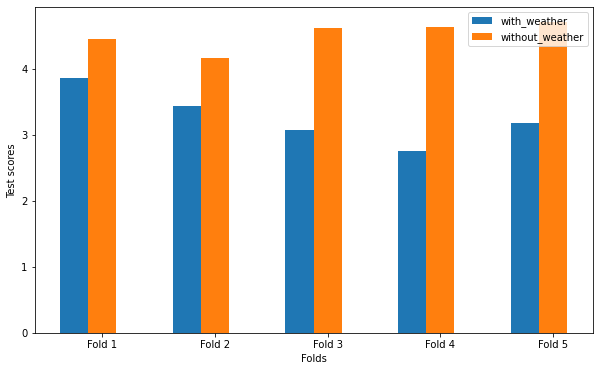

In [17]:
x_with_weather = np.arange(5)
x_without_weather = x_with_weather+0.25
y_with_weather = test_scores_for_weather["with_weather"].values()
y_without_weather = test_scores_for_weather["without_weather"].values()
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x_with_weather, y_with_weather, width=0.25, label='with_weather')
ax.bar(x_without_weather, y_without_weather, width=0.25, label='without_weather')
ax.set_xticks(x_with_weather + 0.25)
ax.set_xticklabels([f"Fold {i+1}" for i in range(len(y_without_weather))])
ax.set_xlabel('Folds')
ax.set_ylabel('Test scores')
ax.legend()
plt.show()

As you can see in the chart above adding weather features improves model performance across all test periods. Hence we can start considering using hourly temperature and humidity values in our demand forecasting model. The results are promising but there is a significant difrerence between the way we used the 2 feautures above and the way we would try to forecast the electricity consumption for tomorrow. If you were in 2018 and you had decided to use 2 new features forecasted by 3rd party data source, as we do above, you probably could only get actual values of features for your historical data. Therefore, the test results don't include the forecasting error of data source if we haven't already stored daily forecasts. To not be too optimistic and accurately simulate the daily forecasting procees  we can add some noise to the test data with the same error distribution of our data source. When we add noise to the test sets model performance will decrease as the error value increases. 

At this moment, the key question arises. There assumed an normally distributed error in the test set, should we add noise to actual values of the 2 features in the training data in the same distribution of test set error. Notice that because we don't have historical forecasts of temperature and humidity for 2018, we treat the noise we are going add to test data as the actual error of weather forecasting source and consider to add a similar error to the train data to improve the performance or robustness of forecasting model.

In the code below we benchmark the model that we train with the actual values of weather features, with the model that we train with noised values of weather features for different normally distributed errors having different standart deviations.

In [ ]:
# Define the list of features to use
feature_list = feature_lists["with_weather"]

# Define dictionaries to store the validation and testing scores, as well as the training, validation, and testing sets
valid_scores={}
test_scores={}
trains={}
valids={}
tests={}

# Define a range of standard deviations to add noise to the testing set
errors=np.array([0.5,1,1.5,2,2.5,3,5,10,20])/100

# Iterate through each standard deviation
for std_dev in errors:
    
    # Initialize dictionaries for the current standard deviation
    valid_scores[f"std_{std_dev}"]={}
    test_scores[f"std_{std_dev}"]={}
    trains[f"std_{std_dev}"]={}
    valids[f"std_{std_dev}"]={}
    tests[f"std_{std_dev}"]={}
    
    # Iterate through whether or not to add noise to the training set
    for train_noise in [True,False]:
        
        # Initialize dictionaries for the current standard deviation and train noise flag
        valid_scores[f"std_{std_dev}"][f"train_noise_{train_noise}"]={}
        test_scores[f"std_{std_dev}"][f"train_noise_{train_noise}"]={}
        trains[f"std_{std_dev}"][f"train_noise_{train_noise}"]={}
        valids[f"std_{std_dev}"][f"train_noise_{train_noise}"]={}
        tests[f"std_{std_dev}"][f"train_noise_{train_noise}"]={}
        
        # Iterate through each fold of the cross-validation
        for fold in folds:

            # Split the data into training, validation, and testing sets based on the fold periods
            train_period = (df["time"]<folds[f"{fold}"]["valid_start"]) 
            valid_period = (df["time"]>=folds[f"{fold}"]["valid_start"]) & (df["time"]<folds[f"{fold}"]["test_start"])
            test_period = (df["time"]>=folds[f"{fold}"]["test_start"]) & (df["time"]<=folds[f"{fold}"]["test_end"])

            train = df[train_period ].copy()
            train = train[~pd.isnull(train[TARGET])]

            valid = df[valid_period].copy()
            valid  = valid[~pd.isnull(valid[TARGET])]

            test  = df[test_period].copy()
            test  = test[~pd.isnull(test[TARGET])]

            # Add noise to the testing set based on the current standard deviation
            test["temp"]*=np.random.normal(1,std_dev,len(test))
            test["humidity"]*=np.random.normal(1,std_dev,len(test))

            # Add noise to the training and validation sets if specified
            if train_noise==True:
                train["temp"]*=np.random.normal(1,std_dev,len(train))
                train["humidity"]*=np.random.normal(1,std_dev,len(train))

                valid["temp"]*=np.random.normal(1,std_dev,len(valid))
                valid["humidity"]*=np.random.normal(1,std_dev,len(valid))

            # Create LightGBM datasets for training and validation
            X_train  = train[feature_list].copy()
            X_valid  = valid[feature_list].copy()
            X_test   = test[feature_list].copy()

            y_train = (train[TARGET].values)
            y_val   = (valid[TARGET].values)
            y_test   = (test[TARGET].values)

            train_dataset = lgb.Dataset(X_train, y_train)
            val_dataset   = lgb.Dataset(X_valid, y_val)

            # Initialize the predictions for the validation and testing sets
            valid["preds"] = 0
            test["preds"] = 0

            # Train multiple models with different random seeds and average the predictions
            for i in range(0,Seed):
                print("Seed--",i)
                parameters["seed"]  = i
                model = lgb.train(params = parameters, 
                                  train_set = train_dataset, 
                                  valid_sets = [val_dataset], 
                                  feval = mape,
                                  early_stopping_rounds = 250,
                                  verbose_eval = 100,
                                  num_boost_round = iterations)

                valid["preds"] = valid["preds"] + model.predict(X_valid,num_iteration=model.best_iteration)
                test["preds"] = test["preds"] + model.predict(X_test,num_iteration=model.best_iteration)

            # Average the predictions across the multiple models
            valid["preds"] = valid["preds"]/Seed
            test["preds"] = test["preds"]/Seed

            # Calculate the mean absolute percentage error for the validation and testing sets
            valid["mape"] = 100*abs(valid[TARGET]-valid["preds"])/valid[TARGET]
            test["mape"] = 100*abs(test[TARGET]-test["preds"])/test[TARGET]

            # Store the mean absolute percentage error scores and the training, validation, and testing sets for the current fold and parameters
            valid_scores[f"std_{std_dev}"][f"train_noise_{train_noise}"][fold] =valid["mape"].mean()
            test_scores[f"std_{std_dev}"][f"train_noise_{train_noise}"][fold] = test["mape"].mean()
            trains[f"std_{std_dev}"][f"train_noise_{train_noise}"][fold]=train.copy()
            valids[f"std_{std_dev}"][f"train_noise_{train_noise}"][fold]=valid.copy()
            tests[f"std_{std_dev}"][f"train_noise_{train_noise}"][fold] =test.copy()

            

Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 980.659	valid_0's mape: 3.4484
[200]	valid_0's l1: 934.105	valid_0's mape: 3.28576
[300]	valid_0's l1: 914.627	valid_0's mape: 3.22182
[400]	valid_0's l1: 905.645	valid_0's mape: 3.18761
[500]	valid_0's l1: 894.373	valid_0's mape: 3.1432
[600]	valid_0's l1: 892.776	valid_0's mape: 3.13513
[700]	valid_0's l1: 892.186	valid_0's mape: 3.1321
[800]	valid_0's l1: 887.856	valid_0's mape: 3.11343
[900]	valid_0's l1: 889.126	valid_0's mape: 3.11684
[1000]	valid_0's l1: 888.466	valid_0's mape: 3.11401
Early stopping, best iteration is:
[770]	valid_0's l1: 887.094	valid_0's mape: 3.11076
Seed-- 1
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1004.36	valid_0's mape: 3.53094
[200]	valid_0's l1: 963.497	valid_0's mape: 3.39221
[300]	valid_0's l1: 956.266	valid_0's mape: 3.36294
[400]	valid_0's l1: 950.682	valid_0's mape: 3.33743
[500]	valid_0's l1: 943.048	valid_0's mape: 3

[300]	valid_0's l1: 1005.34	valid_0's mape: 3.52447
[400]	valid_0's l1: 1001.76	valid_0's mape: 3.51221
[500]	valid_0's l1: 991.622	valid_0's mape: 3.47544
[600]	valid_0's l1: 984.027	valid_0's mape: 3.44632
[700]	valid_0's l1: 982.034	valid_0's mape: 3.43724
[800]	valid_0's l1: 979.895	valid_0's mape: 3.42889
[900]	valid_0's l1: 975.744	valid_0's mape: 3.4131
[1000]	valid_0's l1: 973.766	valid_0's mape: 3.40567
[1100]	valid_0's l1: 973.352	valid_0's mape: 3.40387
[1200]	valid_0's l1: 972.417	valid_0's mape: 3.3998
[1300]	valid_0's l1: 973.409	valid_0's mape: 3.40288
[1400]	valid_0's l1: 971.977	valid_0's mape: 3.39525
[1500]	valid_0's l1: 972.559	valid_0's mape: 3.3961
Early stopping, best iteration is:
[1307]	valid_0's l1: 970.922	valid_0's mape: 3.39396
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 970.787	valid_0's mape: 3.38378
[200]	valid_0's l1: 956.012	valid_0's mape: 3.33166
[300]	valid_0's l1: 936.865	valid_0's mape: 3.26579
[400]	

[300]	valid_0's l1: 1079.32	valid_0's mape: 3.8192
Early stopping, best iteration is:
[56]	valid_0's l1: 1055.34	valid_0's mape: 3.74502
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 747.144	valid_0's mape: 2.68408
[200]	valid_0's l1: 719.138	valid_0's mape: 2.58149
[300]	valid_0's l1: 709.917	valid_0's mape: 2.54273
[400]	valid_0's l1: 708.22	valid_0's mape: 2.53495
[500]	valid_0's l1: 704.394	valid_0's mape: 2.52017
[600]	valid_0's l1: 700.742	valid_0's mape: 2.50731
[700]	valid_0's l1: 699.347	valid_0's mape: 2.50127
[800]	valid_0's l1: 698.499	valid_0's mape: 2.49699
[900]	valid_0's l1: 693.692	valid_0's mape: 2.47931
[1000]	valid_0's l1: 694.573	valid_0's mape: 2.48118
[1100]	valid_0's l1: 692.866	valid_0's mape: 2.47458
[1200]	valid_0's l1: 691.681	valid_0's mape: 2.46951
[1300]	valid_0's l1: 691.763	valid_0's mape: 2.46988
[1400]	valid_0's l1: 692.61	valid_0's mape: 2.4721
Early stopping, best iteration is:
[1241]	valid_0's l1: 690.86

[400]	valid_0's l1: 817.86	valid_0's mape: 2.90701
[500]	valid_0's l1: 819.332	valid_0's mape: 2.91096
[600]	valid_0's l1: 816.689	valid_0's mape: 2.90041
[700]	valid_0's l1: 814.004	valid_0's mape: 2.89278
[800]	valid_0's l1: 814.897	valid_0's mape: 2.89698
[900]	valid_0's l1: 812.976	valid_0's mape: 2.88823
Early stopping, best iteration is:
[652]	valid_0's l1: 811.615	valid_0's mape: 2.88402
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 856.641	valid_0's mape: 3.0413
[200]	valid_0's l1: 842.37	valid_0's mape: 2.9844
[300]	valid_0's l1: 839.379	valid_0's mape: 2.96928
[400]	valid_0's l1: 836.877	valid_0's mape: 2.96447
[500]	valid_0's l1: 838.589	valid_0's mape: 2.97177
Early stopping, best iteration is:
[323]	valid_0's l1: 834.621	valid_0's mape: 2.95551
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 774.263	valid_0's mape: 2.71554
[200]	valid_0's l1: 733.366	valid_0's mape: 2.57197
[300]	valid_

[100]	valid_0's l1: 932.255	valid_0's mape: 3.34101
[200]	valid_0's l1: 980.82	valid_0's mape: 3.52102
[300]	valid_0's l1: 989.295	valid_0's mape: 3.54821
Early stopping, best iteration is:
[67]	valid_0's l1: 906.85	valid_0's mape: 3.24811
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1173.09	valid_0's mape: 4.06719
[200]	valid_0's l1: 1139.03	valid_0's mape: 3.94271
[300]	valid_0's l1: 1134.8	valid_0's mape: 3.91859
[400]	valid_0's l1: 1133.64	valid_0's mape: 3.9047
[500]	valid_0's l1: 1127.46	valid_0's mape: 3.88376
[600]	valid_0's l1: 1123.85	valid_0's mape: 3.86816
[700]	valid_0's l1: 1121.97	valid_0's mape: 3.86146
[800]	valid_0's l1: 1120.88	valid_0's mape: 3.85593
[900]	valid_0's l1: 1119.08	valid_0's mape: 3.84892
[1000]	valid_0's l1: 1119.4	valid_0's mape: 3.84819
[1100]	valid_0's l1: 1114.97	valid_0's mape: 3.82925
[1200]	valid_0's l1: 1119.26	valid_0's mape: 3.83897
Early stopping, best iteration is:
[1035]	valid_0's l1: 1114.33	v

[100]	valid_0's l1: 1133.02	valid_0's mape: 3.89891
[200]	valid_0's l1: 1120.4	valid_0's mape: 3.85729
[300]	valid_0's l1: 1123.94	valid_0's mape: 3.86077
[400]	valid_0's l1: 1122.51	valid_0's mape: 3.85264
[500]	valid_0's l1: 1124.26	valid_0's mape: 3.8564
Early stopping, best iteration is:
[264]	valid_0's l1: 1114.11	valid_0's mape: 3.82717
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1169.95	valid_0's mape: 4.00928
[200]	valid_0's l1: 1141.95	valid_0's mape: 3.91292
[300]	valid_0's l1: 1125.76	valid_0's mape: 3.85663
[400]	valid_0's l1: 1113.34	valid_0's mape: 3.80989
[500]	valid_0's l1: 1115.61	valid_0's mape: 3.81583
[600]	valid_0's l1: 1114.58	valid_0's mape: 3.81545
Early stopping, best iteration is:
[406]	valid_0's l1: 1112.78	valid_0's mape: 3.80803
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1084.47	valid_0's mape: 3.7067
[200]	valid_0's l1: 1052.78	valid_0's mape: 3.59767
[300]	valid

[500]	valid_0's l1: 708.798	valid_0's mape: 2.52623
[600]	valid_0's l1: 710.627	valid_0's mape: 2.53311
[700]	valid_0's l1: 708.371	valid_0's mape: 2.52337
[800]	valid_0's l1: 703.134	valid_0's mape: 2.50412
[900]	valid_0's l1: 703.457	valid_0's mape: 2.50575
[1000]	valid_0's l1: 702.931	valid_0's mape: 2.50349
Early stopping, best iteration is:
[818]	valid_0's l1: 702.352	valid_0's mape: 2.50191
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 763.929	valid_0's mape: 2.72602
[200]	valid_0's l1: 733.191	valid_0's mape: 2.61951
[300]	valid_0's l1: 718.371	valid_0's mape: 2.56289
[400]	valid_0's l1: 714.431	valid_0's mape: 2.55041
[500]	valid_0's l1: 708.102	valid_0's mape: 2.52829
[600]	valid_0's l1: 703.282	valid_0's mape: 2.51003
[700]	valid_0's l1: 698.924	valid_0's mape: 2.49059
[800]	valid_0's l1: 696.962	valid_0's mape: 2.48316
[900]	valid_0's l1: 696.889	valid_0's mape: 2.482
[1000]	valid_0's l1: 695.795	valid_0's mape: 2.47666
[1100]	val

[800]	valid_0's l1: 753.256	valid_0's mape: 2.62362
Early stopping, best iteration is:
[558]	valid_0's l1: 751.351	valid_0's mape: 2.62092
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 788.401	valid_0's mape: 2.75847
[200]	valid_0's l1: 781.154	valid_0's mape: 2.72481
[300]	valid_0's l1: 767.363	valid_0's mape: 2.67278
[400]	valid_0's l1: 764.533	valid_0's mape: 2.65912
[500]	valid_0's l1: 763.205	valid_0's mape: 2.65323
[600]	valid_0's l1: 762.825	valid_0's mape: 2.64925
[700]	valid_0's l1: 761.784	valid_0's mape: 2.64108
[800]	valid_0's l1: 761.154	valid_0's mape: 2.63719
[900]	valid_0's l1: 760.201	valid_0's mape: 2.63449
[1000]	valid_0's l1: 762.806	valid_0's mape: 2.64278
Early stopping, best iteration is:
[778]	valid_0's l1: 758.304	valid_0's mape: 2.62674
Seed-- 1
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 743.745	valid_0's mape: 2.58179
[200]	valid_0's l1: 723.547	valid_0's mape: 2.50903
[300]	v

[200]	valid_0's l1: 1189.12	valid_0's mape: 4.08583
[300]	valid_0's l1: 1188.57	valid_0's mape: 4.08003
[400]	valid_0's l1: 1191.78	valid_0's mape: 4.08694
Early stopping, best iteration is:
[236]	valid_0's l1: 1183.16	valid_0's mape: 4.065
Seed-- 1
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1238	valid_0's mape: 4.25227
[200]	valid_0's l1: 1214.95	valid_0's mape: 4.17241
[300]	valid_0's l1: 1206.4	valid_0's mape: 4.13359
[400]	valid_0's l1: 1201.9	valid_0's mape: 4.11588
[500]	valid_0's l1: 1205.12	valid_0's mape: 4.12441
[600]	valid_0's l1: 1210.68	valid_0's mape: 4.14237
Early stopping, best iteration is:
[372]	valid_0's l1: 1200.78	valid_0's mape: 4.11144
Seed-- 2
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1240.19	valid_0's mape: 4.26331
[200]	valid_0's l1: 1209.37	valid_0's mape: 4.14551
[300]	valid_0's l1: 1202.37	valid_0's mape: 4.1113
[400]	valid_0's l1: 1203.77	valid_0's mape: 4.11096
Early stopping, 

[200]	valid_0's l1: 1171.34	valid_0's mape: 4.13501
[300]	valid_0's l1: 1180.62	valid_0's mape: 4.16079
[400]	valid_0's l1: 1184.45	valid_0's mape: 4.1695
Early stopping, best iteration is:
[150]	valid_0's l1: 1154.83	valid_0's mape: 4.08656
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1214.08	valid_0's mape: 4.29372
[200]	valid_0's l1: 1214.07	valid_0's mape: 4.28474
[300]	valid_0's l1: 1201.97	valid_0's mape: 4.23282
[400]	valid_0's l1: 1190.28	valid_0's mape: 4.18911
[500]	valid_0's l1: 1189.56	valid_0's mape: 4.18047
[600]	valid_0's l1: 1201.54	valid_0's mape: 4.22338
[700]	valid_0's l1: 1204.05	valid_0's mape: 4.23157
Early stopping, best iteration is:
[470]	valid_0's l1: 1189.07	valid_0's mape: 4.18228
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 747.144	valid_0's mape: 2.68408
[200]	valid_0's l1: 719.138	valid_0's mape: 2.58149
[300]	valid_0's l1: 709.917	valid_0's mape: 2.54273
[400]	val

[700]	valid_0's l1: 804.253	valid_0's mape: 2.86612
[800]	valid_0's l1: 802.229	valid_0's mape: 2.85927
[900]	valid_0's l1: 803.053	valid_0's mape: 2.86189
[1000]	valid_0's l1: 801.319	valid_0's mape: 2.85384
[1100]	valid_0's l1: 802.363	valid_0's mape: 2.85814
[1200]	valid_0's l1: 801.519	valid_0's mape: 2.85476
Early stopping, best iteration is:
[1017]	valid_0's l1: 800.768	valid_0's mape: 2.85166
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 867.798	valid_0's mape: 3.08983
[200]	valid_0's l1: 834.263	valid_0's mape: 2.9647
[300]	valid_0's l1: 825.71	valid_0's mape: 2.93488
[400]	valid_0's l1: 817.86	valid_0's mape: 2.90701
[500]	valid_0's l1: 819.332	valid_0's mape: 2.91096
[600]	valid_0's l1: 816.689	valid_0's mape: 2.90041
[700]	valid_0's l1: 814.004	valid_0's mape: 2.89278
[800]	valid_0's l1: 814.897	valid_0's mape: 2.89698
[900]	valid_0's l1: 812.976	valid_0's mape: 2.88823
Early stopping, best iteration is:
[652]	valid_0's l1: 811.61

[100]	valid_0's l1: 1029.41	valid_0's mape: 3.69765
[200]	valid_0's l1: 1030.35	valid_0's mape: 3.68976
[300]	valid_0's l1: 1049.89	valid_0's mape: 3.75385
Early stopping, best iteration is:
[54]	valid_0's l1: 969.888	valid_0's mape: 3.48247
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 933.1	valid_0's mape: 3.36481
[200]	valid_0's l1: 928.123	valid_0's mape: 3.34038
[300]	valid_0's l1: 922.464	valid_0's mape: 3.31745
[400]	valid_0's l1: 942.385	valid_0's mape: 3.39025
[500]	valid_0's l1: 939.097	valid_0's mape: 3.37471
Early stopping, best iteration is:
[302]	valid_0's l1: 920.939	valid_0's mape: 3.31198
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 932.255	valid_0's mape: 3.34101
[200]	valid_0's l1: 980.82	valid_0's mape: 3.52102
[300]	valid_0's l1: 989.295	valid_0's mape: 3.54821
Early stopping, best iteration is:
[67]	valid_0's l1: 906.85	valid_0's mape: 3.24811
Seed-- 0
Training until validat

[400]	valid_0's l1: 1189.29	valid_0's mape: 4.06281
[500]	valid_0's l1: 1189.76	valid_0's mape: 4.06446
Early stopping, best iteration is:
[260]	valid_0's l1: 1183.6	valid_0's mape: 4.04752
Seed-- 1
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1218.52	valid_0's mape: 4.1835
[200]	valid_0's l1: 1226.28	valid_0's mape: 4.19695
[300]	valid_0's l1: 1210.44	valid_0's mape: 4.14638
[400]	valid_0's l1: 1207.95	valid_0's mape: 4.13832
[500]	valid_0's l1: 1204.58	valid_0's mape: 4.1253
[600]	valid_0's l1: 1207.65	valid_0's mape: 4.13065
[700]	valid_0's l1: 1213.75	valid_0's mape: 4.14777
Early stopping, best iteration is:
[539]	valid_0's l1: 1202.76	valid_0's mape: 4.11762
Seed-- 2
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1246.16	valid_0's mape: 4.26179
[200]	valid_0's l1: 1240.43	valid_0's mape: 4.23985
[300]	valid_0's l1: 1238.61	valid_0's mape: 4.2255
[400]	valid_0's l1: 1237.85	valid_0's mape: 4.22169
[500]	valid_

[2500]	valid_0's l1: 684.691	valid_0's mape: 2.42886
[2600]	valid_0's l1: 684.891	valid_0's mape: 2.4293
Early stopping, best iteration is:
[2431]	valid_0's l1: 684.285	valid_0's mape: 2.42697
Seed-- 2
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 758.021	valid_0's mape: 2.70334
[200]	valid_0's l1: 723.598	valid_0's mape: 2.58127
[300]	valid_0's l1: 717.259	valid_0's mape: 2.55776
[400]	valid_0's l1: 713.912	valid_0's mape: 2.54546
[500]	valid_0's l1: 708.908	valid_0's mape: 2.53001
[600]	valid_0's l1: 707.52	valid_0's mape: 2.52582
[700]	valid_0's l1: 703.663	valid_0's mape: 2.51205
[800]	valid_0's l1: 699.939	valid_0's mape: 2.49934
[900]	valid_0's l1: 697.76	valid_0's mape: 2.49173
[1000]	valid_0's l1: 697.094	valid_0's mape: 2.48983
[1100]	valid_0's l1: 698.004	valid_0's mape: 2.49303
[1200]	valid_0's l1: 697.999	valid_0's mape: 2.49238
[1300]	valid_0's l1: 698.249	valid_0's mape: 2.49379
Early stopping, best iteration is:
[1071]	valid_0's l1: 69

[100]	valid_0's l1: 778.494	valid_0's mape: 2.722
[200]	valid_0's l1: 756.146	valid_0's mape: 2.64178
[300]	valid_0's l1: 749.028	valid_0's mape: 2.61888
[400]	valid_0's l1: 745.501	valid_0's mape: 2.6059
[500]	valid_0's l1: 743.348	valid_0's mape: 2.59812
[600]	valid_0's l1: 744.077	valid_0's mape: 2.6005
[700]	valid_0's l1: 742.997	valid_0's mape: 2.5973
[800]	valid_0's l1: 741.835	valid_0's mape: 2.59335
[900]	valid_0's l1: 741.144	valid_0's mape: 2.59041
[1000]	valid_0's l1: 736.692	valid_0's mape: 2.57964
[1100]	valid_0's l1: 736.736	valid_0's mape: 2.58006
[1200]	valid_0's l1: 735.959	valid_0's mape: 2.57723
[1300]	valid_0's l1: 737.518	valid_0's mape: 2.58132
[1400]	valid_0's l1: 737.258	valid_0's mape: 2.58002
Early stopping, best iteration is:
[1182]	valid_0's l1: 735.37	valid_0's mape: 2.57549
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 796.402	valid_0's mape: 2.78623
[200]	valid_0's l1: 765.509	valid_0's mape: 2.67807
[300]	vali

[1200]	valid_0's l1: 1153.74	valid_0's mape: 3.93707
[1300]	valid_0's l1: 1149.03	valid_0's mape: 3.92224
[1400]	valid_0's l1: 1149.46	valid_0's mape: 3.92327
[1500]	valid_0's l1: 1149.27	valid_0's mape: 3.92206
Early stopping, best iteration is:
[1295]	valid_0's l1: 1148.18	valid_0's mape: 3.91993
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1238.71	valid_0's mape: 4.24637
[200]	valid_0's l1: 1199.52	valid_0's mape: 4.10179
[300]	valid_0's l1: 1192.26	valid_0's mape: 4.07274
[400]	valid_0's l1: 1193.11	valid_0's mape: 4.0764
[500]	valid_0's l1: 1194.27	valid_0's mape: 4.07831
Early stopping, best iteration is:
[314]	valid_0's l1: 1189.88	valid_0's mape: 4.06609
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1275.22	valid_0's mape: 4.38168
[200]	valid_0's l1: 1241.55	valid_0's mape: 4.25419
[300]	valid_0's l1: 1228.51	valid_0's mape: 4.19937
[400]	valid_0's l1: 1220.04	valid_0's mape: 4.16674
[500

[100]	valid_0's l1: 1176.88	valid_0's mape: 4.01316
[200]	valid_0's l1: 1169.94	valid_0's mape: 4.00008
[300]	valid_0's l1: 1161.31	valid_0's mape: 3.97342
[400]	valid_0's l1: 1156.48	valid_0's mape: 3.95512
[500]	valid_0's l1: 1166.96	valid_0's mape: 3.99197
Early stopping, best iteration is:
[338]	valid_0's l1: 1154.47	valid_0's mape: 3.95017
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1234.22	valid_0's mape: 4.36754
[200]	valid_0's l1: 1215.44	valid_0's mape: 4.3019
[300]	valid_0's l1: 1221.28	valid_0's mape: 4.31371
[400]	valid_0's l1: 1219.18	valid_0's mape: 4.3041
Early stopping, best iteration is:
[221]	valid_0's l1: 1204.44	valid_0's mape: 4.26118
Seed-- 1
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1221.32	valid_0's mape: 4.34277
[200]	valid_0's l1: 1212.16	valid_0's mape: 4.29463
[300]	valid_0's l1: 1190	valid_0's mape: 4.20432
[400]	valid_0's l1: 1189.01	valid_0's mape: 4.19814
[500]	valid_0

Seed-- 1
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 849.747	valid_0's mape: 3.03018
[200]	valid_0's l1: 809.165	valid_0's mape: 2.87872
[300]	valid_0's l1: 802.651	valid_0's mape: 2.85063
[400]	valid_0's l1: 793.58	valid_0's mape: 2.81833
[500]	valid_0's l1: 792.889	valid_0's mape: 2.81744
[600]	valid_0's l1: 790.832	valid_0's mape: 2.80887
[700]	valid_0's l1: 789.27	valid_0's mape: 2.80354
[800]	valid_0's l1: 789.089	valid_0's mape: 2.80276
[900]	valid_0's l1: 789.96	valid_0's mape: 2.80678
[1000]	valid_0's l1: 788.449	valid_0's mape: 2.80117
[1100]	valid_0's l1: 788.153	valid_0's mape: 2.79975
[1200]	valid_0's l1: 786.456	valid_0's mape: 2.79304
[1300]	valid_0's l1: 783.954	valid_0's mape: 2.78424
[1400]	valid_0's l1: 782.372	valid_0's mape: 2.77811
[1500]	valid_0's l1: 781.569	valid_0's mape: 2.77545
[1600]	valid_0's l1: 781.716	valid_0's mape: 2.77559
[1700]	valid_0's l1: 782.231	valid_0's mape: 2.77655
[1800]	valid_0's l1: 783.743	valid_0's m

[500]	valid_0's l1: 757.435	valid_0's mape: 2.60401
[600]	valid_0's l1: 758.415	valid_0's mape: 2.60671
[700]	valid_0's l1: 759.537	valid_0's mape: 2.60894
Early stopping, best iteration is:
[535]	valid_0's l1: 756.824	valid_0's mape: 2.6023
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 761.316	valid_0's mape: 2.6501
[200]	valid_0's l1: 737.528	valid_0's mape: 2.56311
[300]	valid_0's l1: 735.41	valid_0's mape: 2.55087
[400]	valid_0's l1: 731.519	valid_0's mape: 2.53726
[500]	valid_0's l1: 731.364	valid_0's mape: 2.53437
[600]	valid_0's l1: 730.871	valid_0's mape: 2.53324
[700]	valid_0's l1: 733.372	valid_0's mape: 2.54198
[800]	valid_0's l1: 732.907	valid_0's mape: 2.53827
Early stopping, best iteration is:
[558]	valid_0's l1: 729.415	valid_0's mape: 2.52839
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 917.001	valid_0's mape: 3.28586
[200]	valid_0's l1: 927.018	valid_0's mape: 3.31862
[300]	valid

[1500]	valid_0's l1: 1210.27	valid_0's mape: 4.12568
[1600]	valid_0's l1: 1212.23	valid_0's mape: 4.13162
[1700]	valid_0's l1: 1211.1	valid_0's mape: 4.12722
Early stopping, best iteration is:
[1471]	valid_0's l1: 1209.97	valid_0's mape: 4.1246
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1289.8	valid_0's mape: 4.40469
[200]	valid_0's l1: 1252.55	valid_0's mape: 4.28281
[300]	valid_0's l1: 1247.89	valid_0's mape: 4.26575
[400]	valid_0's l1: 1241.21	valid_0's mape: 4.24001
[500]	valid_0's l1: 1238.03	valid_0's mape: 4.22982
[600]	valid_0's l1: 1232.95	valid_0's mape: 4.20837
[700]	valid_0's l1: 1224.6	valid_0's mape: 4.18248
[800]	valid_0's l1: 1225.9	valid_0's mape: 4.18305
[900]	valid_0's l1: 1226.49	valid_0's mape: 4.1843
[1000]	valid_0's l1: 1225.71	valid_0's mape: 4.18116
Early stopping, best iteration is:
[788]	valid_0's l1: 1222.29	valid_0's mape: 4.17218
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	val

[100]	valid_0's l1: 1299.32	valid_0's mape: 4.58502
[200]	valid_0's l1: 1289.55	valid_0's mape: 4.53742
[300]	valid_0's l1: 1302.63	valid_0's mape: 4.57665
[400]	valid_0's l1: 1298.47	valid_0's mape: 4.56088
Early stopping, best iteration is:
[173]	valid_0's l1: 1283.14	valid_0's mape: 4.51776
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1271.05	valid_0's mape: 4.50463
[200]	valid_0's l1: 1266.53	valid_0's mape: 4.48123
[300]	valid_0's l1: 1288.66	valid_0's mape: 4.56029
Early stopping, best iteration is:
[78]	valid_0's l1: 1264.02	valid_0's mape: 4.48621
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 747.144	valid_0's mape: 2.68408
[200]	valid_0's l1: 719.138	valid_0's mape: 2.58149
[300]	valid_0's l1: 709.917	valid_0's mape: 2.54273
[400]	valid_0's l1: 708.22	valid_0's mape: 2.53495
[500]	valid_0's l1: 704.394	valid_0's mape: 2.52017
[600]	valid_0's l1: 700.742	valid_0's mape: 2.50731
[700]	vali

[1000]	valid_0's l1: 801.319	valid_0's mape: 2.85384
[1100]	valid_0's l1: 802.363	valid_0's mape: 2.85814
[1200]	valid_0's l1: 801.519	valid_0's mape: 2.85476
Early stopping, best iteration is:
[1017]	valid_0's l1: 800.768	valid_0's mape: 2.85166
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 867.798	valid_0's mape: 3.08983
[200]	valid_0's l1: 834.263	valid_0's mape: 2.9647
[300]	valid_0's l1: 825.71	valid_0's mape: 2.93488
[400]	valid_0's l1: 817.86	valid_0's mape: 2.90701
[500]	valid_0's l1: 819.332	valid_0's mape: 2.91096
[600]	valid_0's l1: 816.689	valid_0's mape: 2.90041
[700]	valid_0's l1: 814.004	valid_0's mape: 2.89278
[800]	valid_0's l1: 814.897	valid_0's mape: 2.89698
[900]	valid_0's l1: 812.976	valid_0's mape: 2.88823
Early stopping, best iteration is:
[652]	valid_0's l1: 811.615	valid_0's mape: 2.88402
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 856.641	valid_0's mape: 3.0413
[200]	va

[300]	valid_0's l1: 1049.89	valid_0's mape: 3.75385
Early stopping, best iteration is:
[54]	valid_0's l1: 969.888	valid_0's mape: 3.48247
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 933.1	valid_0's mape: 3.36481
[200]	valid_0's l1: 928.123	valid_0's mape: 3.34038
[300]	valid_0's l1: 922.464	valid_0's mape: 3.31745
[400]	valid_0's l1: 942.385	valid_0's mape: 3.39025
[500]	valid_0's l1: 939.097	valid_0's mape: 3.37471
Early stopping, best iteration is:
[302]	valid_0's l1: 920.939	valid_0's mape: 3.31198
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 932.255	valid_0's mape: 3.34101
[200]	valid_0's l1: 980.82	valid_0's mape: 3.52102
[300]	valid_0's l1: 989.295	valid_0's mape: 3.54821
Early stopping, best iteration is:
[67]	valid_0's l1: 906.85	valid_0's mape: 3.24811
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1275.79	valid_0's mape: 4.3845
[200]	valid_0

[300]	valid_0's l1: 1272.16	valid_0's mape: 4.34118
[400]	valid_0's l1: 1254	valid_0's mape: 4.27551
[500]	valid_0's l1: 1241.06	valid_0's mape: 4.22669
[600]	valid_0's l1: 1237.37	valid_0's mape: 4.21475
[700]	valid_0's l1: 1236.03	valid_0's mape: 4.20682
[800]	valid_0's l1: 1230.48	valid_0's mape: 4.19038
[900]	valid_0's l1: 1229.27	valid_0's mape: 4.18936
[1000]	valid_0's l1: 1228.28	valid_0's mape: 4.18414
[1100]	valid_0's l1: 1223.05	valid_0's mape: 4.16669
[1200]	valid_0's l1: 1226.13	valid_0's mape: 4.17556
[1300]	valid_0's l1: 1227.31	valid_0's mape: 4.17822
Early stopping, best iteration is:
[1078]	valid_0's l1: 1222.5	valid_0's mape: 4.16473
Seed-- 4
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1297.06	valid_0's mape: 4.42704
[200]	valid_0's l1: 1255.23	valid_0's mape: 4.29385
[300]	valid_0's l1: 1235.15	valid_0's mape: 4.22569
[400]	valid_0's l1: 1227.79	valid_0's mape: 4.20014
[500]	valid_0's l1: 1219.28	valid_0's mape: 4.16807
[600]	val

[800]	valid_0's l1: 693.888	valid_0's mape: 2.46387
[900]	valid_0's l1: 694.368	valid_0's mape: 2.46492
[1000]	valid_0's l1: 694.145	valid_0's mape: 2.46453
[1100]	valid_0's l1: 692.889	valid_0's mape: 2.46042
[1200]	valid_0's l1: 691.835	valid_0's mape: 2.45627
[1300]	valid_0's l1: 690.944	valid_0's mape: 2.45309
[1400]	valid_0's l1: 690.872	valid_0's mape: 2.45309
[1500]	valid_0's l1: 689.834	valid_0's mape: 2.45011
[1600]	valid_0's l1: 689.591	valid_0's mape: 2.44917
[1700]	valid_0's l1: 689.646	valid_0's mape: 2.44951
[1800]	valid_0's l1: 689.551	valid_0's mape: 2.44889
[1900]	valid_0's l1: 688.679	valid_0's mape: 2.44571
[2000]	valid_0's l1: 687.289	valid_0's mape: 2.43968
[2100]	valid_0's l1: 687.213	valid_0's mape: 2.43928
[2200]	valid_0's l1: 685.958	valid_0's mape: 2.43375
[2300]	valid_0's l1: 684.809	valid_0's mape: 2.42983
[2400]	valid_0's l1: 685.882	valid_0's mape: 2.43382
[2500]	valid_0's l1: 684.691	valid_0's mape: 2.42886
[2600]	valid_0's l1: 684.891	valid_0's mape: 2.4

[200]	valid_0's l1: 742.69	valid_0's mape: 2.59089
[300]	valid_0's l1: 733.225	valid_0's mape: 2.55861
[400]	valid_0's l1: 729.835	valid_0's mape: 2.54735
[500]	valid_0's l1: 726.776	valid_0's mape: 2.53545
[600]	valid_0's l1: 724.232	valid_0's mape: 2.52579
[700]	valid_0's l1: 725.599	valid_0's mape: 2.53153
[800]	valid_0's l1: 726.925	valid_0's mape: 2.53706
Early stopping, best iteration is:
[610]	valid_0's l1: 723.424	valid_0's mape: 2.52349
Seed-- 2
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 781.243	valid_0's mape: 2.73535
[200]	valid_0's l1: 759.318	valid_0's mape: 2.66638
[300]	valid_0's l1: 753.36	valid_0's mape: 2.6439
[400]	valid_0's l1: 745.276	valid_0's mape: 2.61928
[500]	valid_0's l1: 747.403	valid_0's mape: 2.63288
[600]	valid_0's l1: 747.804	valid_0's mape: 2.63276
Early stopping, best iteration is:
[438]	valid_0's l1: 740.004	valid_0's mape: 2.6054
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100]	valid_

[200]	valid_0's l1: 1298.6	valid_0's mape: 4.43146
[300]	valid_0's l1: 1291.23	valid_0's mape: 4.4029
[400]	valid_0's l1: 1281.4	valid_0's mape: 4.37027
[500]	valid_0's l1: 1274	valid_0's mape: 4.34083
[600]	valid_0's l1: 1263.33	valid_0's mape: 4.29992
[700]	valid_0's l1: 1263.5	valid_0's mape: 4.30018
[800]	valid_0's l1: 1258.66	valid_0's mape: 4.28514
[900]	valid_0's l1: 1255.68	valid_0's mape: 4.27434
[1000]	valid_0's l1: 1259.79	valid_0's mape: 4.28873
[1100]	valid_0's l1: 1257.81	valid_0's mape: 4.28249
Early stopping, best iteration is:
[884]	valid_0's l1: 1255.09	valid_0's mape: 4.27223
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1352.48	valid_0's mape: 4.61182
[200]	valid_0's l1: 1275.18	valid_0's mape: 4.35496
[300]	valid_0's l1: 1273.07	valid_0's mape: 4.34523
[400]	valid_0's l1: 1259.68	valid_0's mape: 4.30194
[500]	valid_0's l1: 1255.91	valid_0's mape: 4.29166
[600]	valid_0's l1: 1253.6	valid_0's mape: 4.29038
[700]	valid_0's 

[100]	valid_0's l1: 1238.25	valid_0's mape: 4.20761
[200]	valid_0's l1: 1240.28	valid_0's mape: 4.21569
[300]	valid_0's l1: 1245.37	valid_0's mape: 4.22993
Early stopping, best iteration is:
[119]	valid_0's l1: 1231.54	valid_0's mape: 4.18748
Seed-- 1
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1246.84	valid_0's mape: 4.24391
[200]	valid_0's l1: 1241.12	valid_0's mape: 4.21709
[300]	valid_0's l1: 1245.06	valid_0's mape: 4.22479
Early stopping, best iteration is:
[80]	valid_0's l1: 1219.31	valid_0's mape: 4.14697
Seed-- 2
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1240.71	valid_0's mape: 4.23952
[200]	valid_0's l1: 1232.4	valid_0's mape: 4.21434
[300]	valid_0's l1: 1231.06	valid_0's mape: 4.20717
[400]	valid_0's l1: 1238.94	valid_0's mape: 4.24015
[500]	valid_0's l1: 1252.58	valid_0's mape: 4.29101
Early stopping, best iteration is:
[279]	valid_0's l1: 1223.81	valid_0's mape: 4.18109
Seed-- 3
Training until val

Early stopping, best iteration is:
[1239]	valid_0's l1: 690.248	valid_0's mape: 2.45598
Seed-- 0
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 871.12	valid_0's mape: 3.10911
[200]	valid_0's l1: 824.72	valid_0's mape: 2.93256
[300]	valid_0's l1: 814.963	valid_0's mape: 2.89813
[400]	valid_0's l1: 808.671	valid_0's mape: 2.87279
[500]	valid_0's l1: 805.158	valid_0's mape: 2.86102
[600]	valid_0's l1: 800.489	valid_0's mape: 2.8457
[700]	valid_0's l1: 796.747	valid_0's mape: 2.83199
[800]	valid_0's l1: 795.33	valid_0's mape: 2.8278
[900]	valid_0's l1: 793.76	valid_0's mape: 2.82308
[1000]	valid_0's l1: 793.165	valid_0's mape: 2.81985
[1100]	valid_0's l1: 792.883	valid_0's mape: 2.81892
[1200]	valid_0's l1: 792.095	valid_0's mape: 2.81551
[1300]	valid_0's l1: 791.572	valid_0's mape: 2.81624
[1400]	valid_0's l1: 790.616	valid_0's mape: 2.81195
[1500]	valid_0's l1: 790.645	valid_0's mape: 2.81203
[1600]	valid_0's l1: 790.752	valid_0's mape: 2.81268
[1700]	v

Seed-- 2
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 785.844	valid_0's mape: 2.72329
[200]	valid_0's l1: 757.607	valid_0's mape: 2.61978
[300]	valid_0's l1: 747.017	valid_0's mape: 2.57675
[400]	valid_0's l1: 742.257	valid_0's mape: 2.55922
[500]	valid_0's l1: 741.621	valid_0's mape: 2.56003
[600]	valid_0's l1: 741.96	valid_0's mape: 2.56276
[700]	valid_0's l1: 738.881	valid_0's mape: 2.55293
[800]	valid_0's l1: 738.132	valid_0's mape: 2.55004
[900]	valid_0's l1: 735.073	valid_0's mape: 2.539
[1000]	valid_0's l1: 735.881	valid_0's mape: 2.54173
[1100]	valid_0's l1: 734.323	valid_0's mape: 2.53665
[1200]	valid_0's l1: 737.692	valid_0's mape: 2.54863
[1300]	valid_0's l1: 735.92	valid_0's mape: 2.54358
Early stopping, best iteration is:
[1111]	valid_0's l1: 734.091	valid_0's mape: 2.53589
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 781.818	valid_0's mape: 2.70985
[200]	valid_0's l1: 770.311	valid_0's mape

[2100]	valid_0's l1: 1240.13	valid_0's mape: 4.2729
[2200]	valid_0's l1: 1240.77	valid_0's mape: 4.27498
[2300]	valid_0's l1: 1241.92	valid_0's mape: 4.27875
Early stopping, best iteration is:
[2068]	valid_0's l1: 1239.43	valid_0's mape: 4.27087
Seed-- 1
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1325.22	valid_0's mape: 4.55142
[200]	valid_0's l1: 1300.62	valid_0's mape: 4.47104
[300]	valid_0's l1: 1285.94	valid_0's mape: 4.41415
[400]	valid_0's l1: 1260.88	valid_0's mape: 4.33741
[500]	valid_0's l1: 1255.64	valid_0's mape: 4.32034
[600]	valid_0's l1: 1256.18	valid_0's mape: 4.32205
[700]	valid_0's l1: 1258.98	valid_0's mape: 4.33015
Early stopping, best iteration is:
[544]	valid_0's l1: 1252.52	valid_0's mape: 4.31067
Seed-- 2
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1383.2	valid_0's mape: 4.74532
[200]	valid_0's l1: 1335.3	valid_0's mape: 4.59733
[300]	valid_0's l1: 1310.81	valid_0's mape: 4.51162
[400]	v

[1000]	valid_0's l1: 1224.25	valid_0's mape: 4.31034
Early stopping, best iteration is:
[784]	valid_0's l1: 1218.67	valid_0's mape: 4.29173
Seed-- 2
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1252.42	valid_0's mape: 4.39949
[200]	valid_0's l1: 1244.47	valid_0's mape: 4.35953
[300]	valid_0's l1: 1226.19	valid_0's mape: 4.29836
[400]	valid_0's l1: 1233.63	valid_0's mape: 4.32316
[500]	valid_0's l1: 1226.08	valid_0's mape: 4.29828
[600]	valid_0's l1: 1222.87	valid_0's mape: 4.28773
[700]	valid_0's l1: 1224.85	valid_0's mape: 4.29187
[800]	valid_0's l1: 1223.84	valid_0's mape: 4.28731
Early stopping, best iteration is:
[628]	valid_0's l1: 1219.09	valid_0's mape: 4.27375
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1221.91	valid_0's mape: 4.32639
[200]	valid_0's l1: 1236.06	valid_0's mape: 4.36603
[300]	valid_0's l1: 1235.91	valid_0's mape: 4.35971
Early stopping, best iteration is:
[142]	valid_0's l1: 1204

[1800]	valid_0's l1: 783.743	valid_0's mape: 2.78205
Early stopping, best iteration is:
[1628]	valid_0's l1: 780.953	valid_0's mape: 2.77265
Seed-- 2
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 840.046	valid_0's mape: 2.99782
[200]	valid_0's l1: 816.783	valid_0's mape: 2.90805
[300]	valid_0's l1: 816.42	valid_0's mape: 2.9074
[400]	valid_0's l1: 811.882	valid_0's mape: 2.89195
[500]	valid_0's l1: 806.969	valid_0's mape: 2.87469
[600]	valid_0's l1: 805.182	valid_0's mape: 2.86813
[700]	valid_0's l1: 804.253	valid_0's mape: 2.86612
[800]	valid_0's l1: 802.229	valid_0's mape: 2.85927
[900]	valid_0's l1: 803.053	valid_0's mape: 2.86189
[1000]	valid_0's l1: 801.319	valid_0's mape: 2.85384
[1100]	valid_0's l1: 802.363	valid_0's mape: 2.85814
[1200]	valid_0's l1: 801.519	valid_0's mape: 2.85476
Early stopping, best iteration is:
[1017]	valid_0's l1: 800.768	valid_0's mape: 2.85166
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100

[300]	valid_0's l1: 933.991	valid_0's mape: 3.34255
Early stopping, best iteration is:
[90]	valid_0's l1: 901.763	valid_0's mape: 3.23053
Seed-- 1
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 894.749	valid_0's mape: 3.21685
[200]	valid_0's l1: 901.987	valid_0's mape: 3.23776
[300]	valid_0's l1: 928.071	valid_0's mape: 3.32525
Early stopping, best iteration is:
[99]	valid_0's l1: 894.056	valid_0's mape: 3.21475
Seed-- 2
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 1029.41	valid_0's mape: 3.69765
[200]	valid_0's l1: 1030.35	valid_0's mape: 3.68976
[300]	valid_0's l1: 1049.89	valid_0's mape: 3.75385
Early stopping, best iteration is:
[54]	valid_0's l1: 969.888	valid_0's mape: 3.48247
Seed-- 3
Training until validation scores don't improve for 250 rounds
[100]	valid_0's l1: 933.1	valid_0's mape: 3.36481
[200]	valid_0's l1: 928.123	valid_0's mape: 3.34038
[300]	valid_0's l1: 922.464	valid_0's mape: 3.31745
[400]	valid

After a long training and validation, finally we are able to see the results. 

In [ ]:
for std_dev in errors:
    y_with_noise = [i for i in test_scores[f"std_{std_dev}"][f"train_noise_True"].values()]
    y_without_noise = [i for i in test_scores[f"std_{std_dev}"][f"train_noise_False"].values()]
    y_without_weather = [i for i in test_scores_for_weather["without_weather"].values()]
    x_with_noise = np.arange(len(y_with_noise))
    x_without_noise = x_with_noise + 0.25
    x_without_weather = x_without_noise + 0.25

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x_with_noise, y_with_noise, width=0.25, label='with_noise')
    ax.bar(x_without_noise, y_without_noise, width=0.25, label='without_noise')
    ax.bar(x_without_weather, y_without_weather, width=0.25, label='without_weather')
    ax.set_xticks(x_with_noise + 0.25)
    ax.set_xticklabels([f"Fold {i+1}" for i in range(len(y_with_noise))])
    ax.set_xlabel('Folds')
    ax.set_ylabel('Test scores')
    ax.set_title(f"Standard deviation: {std_dev}")
    ax.legend()
    plt.show()


To sum things up, at first we had a historical electricity consumption data and we extracted some basic and useful features. Then we wanted to add weather data to improve the model performance. We first directly used the weather data in seen data and saw promising result. However, weather data has a different characteristic from historical consumption data. One of it is historical but the other part, probably forecasting period, is forecast of the data source we use. This is why we must simulate the deployment phase of our forecasting model and not decide to use a forecasted features only by validating in historical data. To simulate, we added different amounts of forecasting error to test sets and compared the results when we did and did not add a similar noise signal to the train and validation tests, and we did not use any weather forecasting feature. As you can see in the last figure, if forecasting error is low model performs better than not using any weather features and adding noise to train/validation data improves even more. As forecasting error increases using weather features dramatically decreases model performance and becames the worst thing to do. And even if using weather data gets useless, adding noise to train set protects the model from being misleaded.